#### ReAct Agent Architecture

**Aim: This is the intuition behind ReAct, a general agent architecture.**

- `ACT` - let the model call specific tools
- `OBSERVE` - pass the tool output back to the model
- `REASON` - let the model reason about the tool output and model input to decide what to do next (e.g., call another tool or just respond directly)


![ReAct Architecture](..\assets\ReAct_architecture.jpg)

In [31]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [1]:
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [2]:
pubmed = PubmedQueryRun()
pubmed.invoke("Give me some papers on diabetes?")

'Published: 2025-09-05\nTitle: Complement at the crossroads of inflammation and metabolism: implications for diabetes and metabolic functions.\nCopyright Information: Copyright © 2025 The Author(s). Published by Elsevier GmbH.. All rights reserved.\nSummary::\nDiabetes is a growing global problem, with hundreds of millions of people living with the disease worldwide. Diabetes can be divided into two major subtypes, autoimmune type 1 diabetes (T1D), and type 2 diabetes (T2D), which has stronger causal links in obesity, lifestyle, and age. Although immunity and inflammation are clearly defined in T1D, it is also understood that inflammation has a role in metabolic dysregulation in T2D, inducing insulin resistance as well as affecting β-cell function, survival, and therefore insulin secretion. Cytokines and other inflammatory mediators can affect function of cells important for metabolism, most studied in adipose tissue, muscle, and pancreatic islets. Similarly, evidence shows that comple

In [34]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [35]:
wiki.invoke("What is agenticAI?")

'Page: Agentic AI\nSummary: In artificial intelligence, agentic AI focuses on autonomous systems that can make decisions and perform tasks with limited or no human intervention. The independent systems automatically respond to conditions to produce process results. The field is closely linked to agentic automation, also known as agent-based process management systems, when applied to process automation. Applications include software development, customer support, cybersecurity and business intelli'

In [36]:
from langchain_tavily import TavilySearch
tavily = TavilySearch()

In [37]:
tavily.invoke("Provide me the recent AI news for 12th November 2025")

{'query': 'Provide me the recent AI news for 12th November 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News Daily - November 2025 - YouTube',
   'url': 'https://www.youtube.com/playlist?list=PLICX3YZ4qknh6AK0ICDOAxdHVoSRfstjT',
   'content': 'Latest AI industry news for November 2025 , featuring in-depth analysis of breakthrough developments and trends in artificial intelligence.',
   'score': 0.99986446,
   'raw_content': None},
  {'title': 'The AI Track AI News November 2025: In-Depth and Concise',
   'url': 'https://theaitrack.com/ai-news-november-2025-in-depth-and-concise/',
   'content': '1 week ago - India’s IT ministry unveiled draft rules requiring mandatory AI Labelling of synthetic media, stricter takedown oversight, and public feedback until Nov 6, 2025 .',
   'score': 0.99968743,
   'raw_content': None},
  {'title': 'AI Apps Top AI News for November 2025: Breakthroughs, Launches & Trends You Can’t Miss',
   'url': 'https:/

In [38]:
# Custom Functions - these will be a tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [39]:
# Combining all the tools
tools=[pubmed,wiki,tavily,add,multiply,divide]

In [40]:
# Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=llm.bind_tools(tools)

In [41]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tool to use. The available tools are PubMed, Wikipedia, Tavily Search, and some math functions. Since they want recent news, Tavily Search seems appropriate because it\'s optimized for current events. The math functions don\'t fit here.\n\nLooking at the parameters for Tavily Search, I need to set up the query. The user mentioned "recent," so I should use the time_range parameter. The options are day, week, month, year. "Recent" might mean the last week, so I\'ll set time_range to "week". The topic is AI news, so the query should be "AI news".\n\nAlso, I should check if the topic parameter is needed. The description says to use "news" for politics, sports, or major events covered by mainstream media. AI news could fall under general news, but since the user specified "recent," maybe "general" is okay. But the topic parameter has options "general", "news", "financ

In [42]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'recent AI news', 'time_range': 'week'},
  'id': 'nzg291twf',
  'type': 'tool_call'}]

In [43]:
# State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

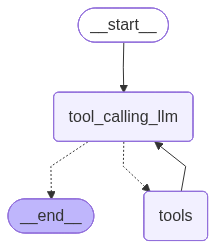

In [44]:
# Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [45]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for November 12th 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for November 12th 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mhk9p2hx8)
 Call ID: mhk9p2hx8
  Args:
    end_date: 2025-11-12
    query: top 10 AI news
    search_depth: advanced
    start_date: 2025-11-12
  add (nqecf0x2d)
 Call ID: nqecf0x2d
  Args:
    a: 5
    b: 5
  multiply (6zwe4hw67)
 Call ID: 6zwe4hw67
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: start_date and end_date cannot be the same')}
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message =========

In [46]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (0ms0vbskr)
 Call ID: 0ms0vbskr
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a field of art

In [47]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (0z3h7pcjc)
 Call ID: 0z3h7pcjc
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The sum of 5 and 8 is **13**.


In [48]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

The input "Divide that by 5" lacks the specific number to divide. Please provide the number you want to divide by 5.


**Agent Memory:**
- Lets introduce Agent With Memory
- This concept is similar to `conversational memory` that is used in Langchain to retain context of past interaction in case future queries require it

**MemorySaver:**
- LangGraph can use a checkpointer to automatically save the graph state after each step.

- This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

- One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

- All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

![Checkpoint Diagram](..\assets\checkpoints.png)

In [49]:
# Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




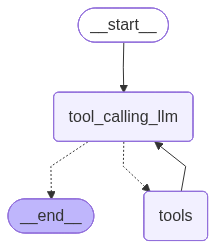

In [50]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [51]:
# Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (eeqde8mv4)
 Call ID: eeqde8mv4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.


In [52]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (eeqde8mv4)
 Call ID: eeqde8mv4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (ejbm5x8fx)
 Call ID: ejbm5x8fx
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 and 25 is **50**. Let me know if you'd like to perform another operatio

In [53]:
messages = [HumanMessage(content="then multiply that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (eeqde8mv4)
 Call ID: eeqde8mv4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (ejbm5x8fx)
 Call ID: ejbm5x8fx
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 and 25 is **50**. Let me know if you'd like to perform another operatio